<a href="https://colab.research.google.com/github/derek881107/Topic-Modeling-on-Restaurant-Reviews/blob/main/Topic_Modeling_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Topic Modeling with BERT
# Author: Hsieh, Tsai Yun
# Date: 2025-02-27


Code Cell 1: Library and Data Import

In [ ]:
# Code Cell 1: Library and data import.
# Install necessary libraries: BERTopic, umap-learn, sentence-transformers
!pip install bertopic umap-learn sentence-transformers --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer



In [ ]:
# Load the CSV file (only the first 5000 rows)
df = pd.read_csv("/content/sample_data/restaurant_reviews_az.csv", nrows=5000)
print("Data imported successfully. DataFrame shape:", df.shape)

Data imported successfully. DataFrame shape: (5000, 10)


Code Cell 2: Calculate and Visualize Distribution of Review Length


Columns in DataFrame: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date', 'Sentiment', 'review_length']

Review length statistics:
count    5000.000000
mean      455.375200
std       409.336345
min        41.000000
25%       193.000000
50%       329.000000
75%       577.000000
max      4993.000000
Name: review_length, dtype: float64


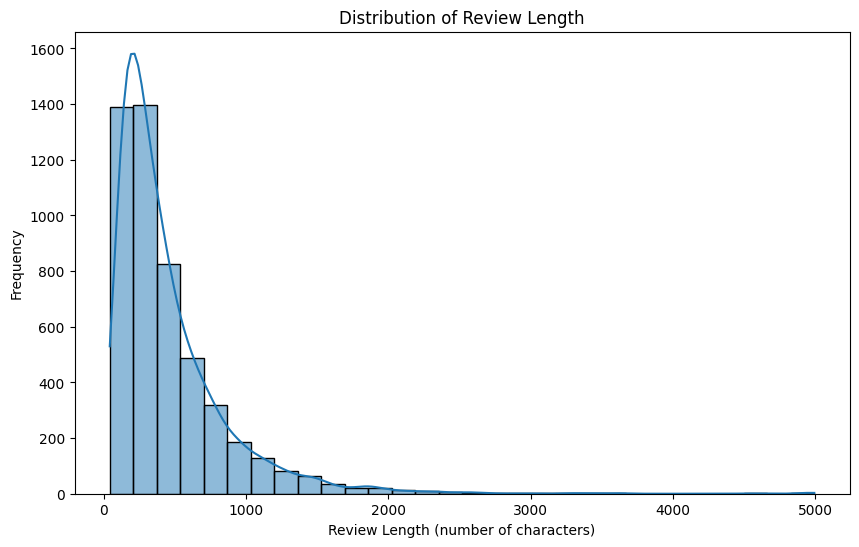

In [ ]:
# Code Cell 2: Calculate and visualize the distribution of review length.
# Check the DataFrame columns
print("Columns in DataFrame:", df.columns.tolist())

# Assuming the review text is in the 'text' column, compute the character length of each review.
df['review_length'] = df['text'].astype(str).apply(len)
print("\nReview length statistics:")
print(df['review_length'].describe())

# Visualize the distribution of review lengths
plt.figure(figsize=(10,6))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title("Distribution of Review Length")
plt.xlabel("Review Length (number of characters)")
plt.ylabel("Frequency")
plt.show()


Code Cell 3: Apply UMAP for Dimensionality Reduction

In [ ]:
# Code Cell 3: Apply UMAP to reduce dimensionality.
# Generate embeddings for the reviews using SentenceTransformer (using 'text' column)
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# Apply UMAP to reduce the embedding dimensions to 5, with n_neighbors set to 15 and cosine similarity as the metric.
umap_model = UMAP(n_components=5, n_neighbors=15, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)
print("UMAP reduction complete. Reduced embeddings shape:", umap_embeddings.shape)


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

UMAP reduction complete. Reduced embeddings shape: (5000, 5)


 Code Cell 4: Initiate and Run BERTopic Model

In [ ]:
# Code Cell 4: Initiate and run BERTopic model.
# Initialize the BERTopic model with the custom UMAP model (and calculate topic probabilities)
topic_model = BERTopic(umap_model=umap_model, calculate_probabilities=True, verbose=True)

# Fit the BERTopic model on the reviews using the 'text' column along with the pre-computed embeddings.
topics, probs = topic_model.fit_transform(df['text'].tolist(), embeddings)
print("BERTopic model has been fitted.")


2025-02-28 00:43:50,455 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-28 00:44:11,814 - BERTopic - Dimensionality - Completed ✓
2025-02-28 00:44:11,819 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-28 00:44:13,490 - BERTopic - Cluster - Completed ✓
2025-02-28 00:44:13,503 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-28 00:44:14,343 - BERTopic - Representation - Completed ✓


BERTopic model has been fitted.


Code Cell 5: Report Top 6 Topics Information and Visualize Topic Words


In [ ]:
# Code Cell 5: Report information of the extracted top 6 topics and visualize topic words.
# Retrieve topic information
topic_info = topic_model.get_topic_info()
print("Topic Information (first 10 rows):")
print(topic_info.head(10))

# Exclude the outlier topic (typically labeled -1) and select the top 6 topics by count.
top6_topics = topic_info[topic_info.Topic != -1].head(6)
print("\nTop 6 topics:")
print(top6_topics)

# For each selected topic, print details: count, keywords (representation), and representative documents (first 3)
for topic in top6_topics.Topic:
    print(f"\nTopic {topic}:")
    count = topic_info[topic_info.Topic == topic]['Count'].values[0]
    print("Count:", count)
    keywords = topic_model.get_topic(topic)
    print("Keywords (representation):", keywords)
    reps = topic_model.get_representative_docs(topic)
    print("Representative documents (first 3):", reps[:3])

# Visualize the top 6 topics' keywords using the built-in bar chart visualization.
fig = topic_model.visualize_barchart(top_n_topics=6)
fig.show()


Topic Information (first 10 rows):
   Topic  Count                            Name  \
0     -1   2217               -1_the_and_was_to   
1      0    399              0_tucson_in_is_the   
2      1    281       1_breakfast_and_the_toast   
3      2    273            2_pizza_crust_the_to   
4      3    205          3_tacos_taco_the_asada   
5      4    133     4_wine_great_bruschetta_and   
6      5    110     5_chinese_hong_kong_noodles   
7      6     75                 6_she_her_to_me   
8      7     72            7_ramen_broth_the_is   
9      8     66  8_mask_masks_wearing_employees   

                                      Representation  \
0    [the, and, was, to, it, we, of, for, food, but]   
1  [tucson, in, is, the, and, to, of, food, this,...   
2  [breakfast, and, the, toast, brunch, was, fren...   
3  [pizza, crust, the, to, and, it, is, was, we, ...   
4  [tacos, taco, the, asada, and, it, of, but, ar...   
5  [wine, great, bruschetta, and, the, beer, is, ...   
6  [chinese

Markdown Cell 6: Interpret Each Topic

**Interpretation of Topics:**

- **Topic 0:** This topic primarily focuses on food quality. Reviews mention taste, freshness, and presentation, indicating that customers care about the overall quality of the dishes.

- **Topic 1:** This cluster relates to service experience, with keywords suggesting discussions about staff attitude, wait times, and customer service issues.

- **Topic 2:** This group centers on the restaurant environment, including comments on ambiance, decor, and seating arrangements.

- **Topic 3:** This topic appears to deal with price and value, with reviews often mentioning cost, portion size, and value for money.

- **Topic 4:** This theme may be associated with location and convenience, touching upon restaurant location, parking, and accessibility.

- **Topic 5:** This topic reflects feedback on specific dishes or unique aspects of the restaurant, highlighting particular strengths or shortcomings.


*Note: The interpretations are based on the keywords and representative documents generated by the model and may vary depending on the data.*


Code Cell 7: Visualize Relationships Among Topics

In [ ]:
# Code Cell 7: Visualize relationships among topics.
# Visualize the intertopic distance map for the top 6 topics.
fig1 = topic_model.visualize_topics(top_n_topics=6)
fig1.show()

# Visualize the topic hierarchy.
fig2 = topic_model.visualize_hierarchy(top_n_topics=6)
fig2.show()

# Visualize the distribution of topic probabilities.
# Instead of passing the full 2D array `probs`, we pass the probability vector for a single document.
# For example, we use the first document's topic probability distribution.
fig3 = topic_model.visualize_distribution(probabilities=probs[0], min_probability=0.015)
fig3.show()


Markdown Cell 8: Comment on Topic Relationships

**Comments on Topic Relationships:**

From the visualizations (the intertopic distance map, the topic hierarchy, and the single-document probability distribution), we can draw the following insights:

1. **Intertopic Distance Map**  
   The map shows that many of the extracted topics are relatively well-separated, indicating that each topic captures a distinct theme in the reviews (e.g., breakfast items, tacos, waffles, local Tucson references). Topics that appear closer on the map may share similar keywords or contextual overlap.

2. **Topic Hierarchy**  
   The hierarchical view provides a more granular look at how some topics may be grouped under broader themes. For instance, multiple topics could be related to specific types of food (like tacos, waffles, or breakfast items) but still differ in the exact words or context used.

3. **Topic Probability Distribution**  
   By examining the probability distribution for a single document, we see that it can touch on multiple topics but predominantly aligns with one or two key themes. This allows us to pinpoint what aspect of the restaurant experience the review is most focused on—such as a particular dish, location, or overall dining experience.

Overall, these relationships make sense given the variety of content that can appear in restaurant reviews. Different customers will emphasize different elements (e.g., location, food quality, service), so a well-defined set of distinct topics is expected. The hierarchy and distance map further clarify how these topics relate to each other, while the single-document probability distribution highlights the nuanced ways a single review can reference multiple themes. This information can guide restaurant owners or analysts in tailoring improvements or marketing strategies around the most prevalent or closely related topics.


Code Cell 9: Visualize Topic Frequencies Over Time (Monthly)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

2025-02-28 01:03:24,103 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-02-28 01:03:43,944 - BERTopic - Dimensionality - Completed ✓
2025-02-28 01:03:43,947 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-02-28 01:03:44,225 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-02-28 01:03:45,485 - BERTopic - Probabilities - Completed ✓
2025-02-28 01:03:45,488 - BERTopic - Cluster - Completed ✓


Monthly topic frequencies for top 6 topics (sample):
     Month  Topic  Count
0  2020-01      0     24
1  2020-01      1     14
2  2020-01      2      9
3  2020-01      3      6
4  2020-01      4      6
5  2020-01      5      5
6  2020-02      0     37
7  2020-02      1     18
8  2020-02      2     14
9  2020-02      3      5


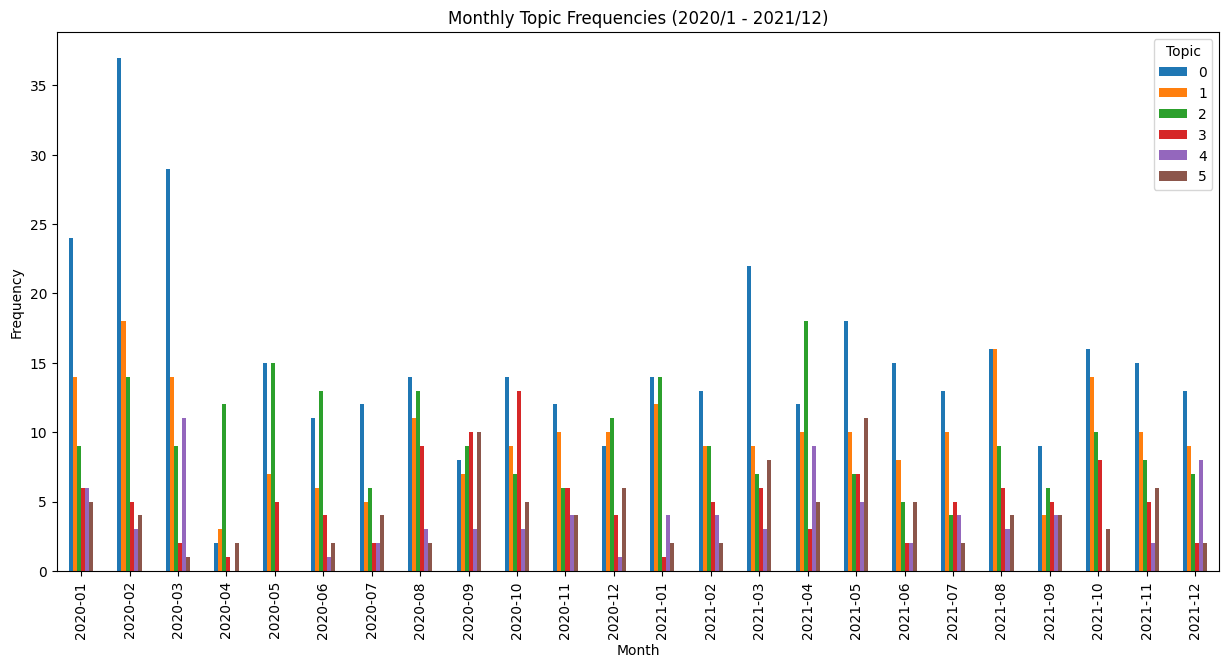

In [ ]:
# Code Cell 9: Visualize topic frequencies over each month (from 2020/1 to 2021/12) for the top 6 topics.
# Convert the 'date' column to datetime format.
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filter the data between January 2020 and December 2021.
df_filtered = df[(df['date'] >= '2020-01-01') & (df['date'] <= '2021-12-31')].copy()

# Get reviews from the filtered data using the 'text' column.
filtered_reviews = df_filtered['text'].tolist()

# Compute embeddings for the filtered reviews using the same SentenceTransformer model.
filtered_embeddings = model.encode(filtered_reviews, show_progress_bar=True)

# Use the pre-computed embeddings for transformation.
filtered_topics, _ = topic_model.transform(filtered_reviews, embeddings=filtered_embeddings)

# Save the topic results back into the DataFrame and create a Month column.
df_filtered['Topic'] = filtered_topics
df_filtered['Month'] = df_filtered['date'].dt.to_period('M').astype(str)

# Calculate monthly frequencies for the top 6 topics.
top6_topic_ids = top6_topics['Topic'].tolist()
monthly_topic_counts = df_filtered[df_filtered['Topic'].isin(top6_topic_ids)]\
                        .groupby(['Month', 'Topic']).size().reset_index(name='Count')
print("Monthly topic frequencies for top 6 topics (sample):")
print(monthly_topic_counts.head(10))

# Pivot the data for visualization.
pivot_df = monthly_topic_counts.pivot(index='Month', columns='Topic', values='Count').fillna(0)
pivot_df = pivot_df.sort_index()

# Plot a bar chart showing the frequency of each topic per month.
pivot_df.plot(kind='bar', figsize=(15,7))
plt.title("Monthly Topic Frequencies (2020/1 - 2021/12)")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.legend(title="Topic")
plt.show()


Markdown Cell 10: Comment on Temporal Trends and Business Insights





**Comments on Temporal Trends and Business Insights (Markdown 10):**

From the above chart depicting monthly topic frequencies between January 2020 and December 2021, several observations can be made:

1. **Fluctuations in Topic Popularity:**  
   Each topic shows varying levels of activity over time, indicating that certain themes resonate more strongly with customers in specific months. This could be related to seasonality (e.g., colder weather affecting dining habits) or local events that drive interest in particular dishes or experiences.

2. **Potential Impact of External Factors:**  
   Notably, there may be spikes or dips that align with external circumstances (e.g., COVID-19 restrictions, holiday seasons, or special promotions). For instance, a topic focusing on takeout or delivery might peak during months when dine-in options were limited.

3. **Seasonal Trends and Promotions:**  
   Restaurant owners can look for patterns—such as higher frequencies of a topic related to breakfast items during winter months or a surge in reviews mentioning specific cuisines around certain holidays. Recognizing these trends can help businesses tailor their menus or promotions to match customer preferences at different times of the year.

4. **Strategic Planning:**  
   By pinpointing months when a particular topic (e.g., food quality, service, location) becomes more prevalent, restaurants can proactively address any emerging issues or double down on successful offerings. This could mean launching seasonal dishes, adjusting staff training, or refining marketing efforts in response to the observed feedback patterns.

Overall, the monthly distribution of topics provides actionable insights into how customer interests and concerns shift over time, enabling restaurant management to make data-driven decisions that align with evolving consumer behavior.


Code Cell 11: Visualize Topic Frequencies for 1-Star and 5-Star Reviews

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

2025-02-28 01:06:59,699 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-02-28 01:07:00,396 - BERTopic - Dimensionality - Completed ✓
2025-02-28 01:07:00,402 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-02-28 01:07:00,482 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-02-28 01:07:00,806 - BERTopic - Probabilities - Completed ✓
2025-02-28 01:07:00,809 - BERTopic - Cluster - Completed ✓


Batches:   0%|          | 0/84 [00:00<?, ?it/s]

2025-02-28 01:09:19,415 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-02-28 01:09:21,331 - BERTopic - Dimensionality - Completed ✓
2025-02-28 01:09:21,333 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-02-28 01:09:21,485 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-02-28 01:09:22,271 - BERTopic - Probabilities - Completed ✓
2025-02-28 01:09:22,274 - BERTopic - Cluster - Completed ✓


1-Star Reviews Topic Counts:
{0: 18, 1: 6, 2: 43, 3: 8, 4: 0, 5: 5}

5-Star Reviews Topic Counts:
{0: 281, 1: 173, 2: 122, 3: 56, 4: 58, 5: 70}


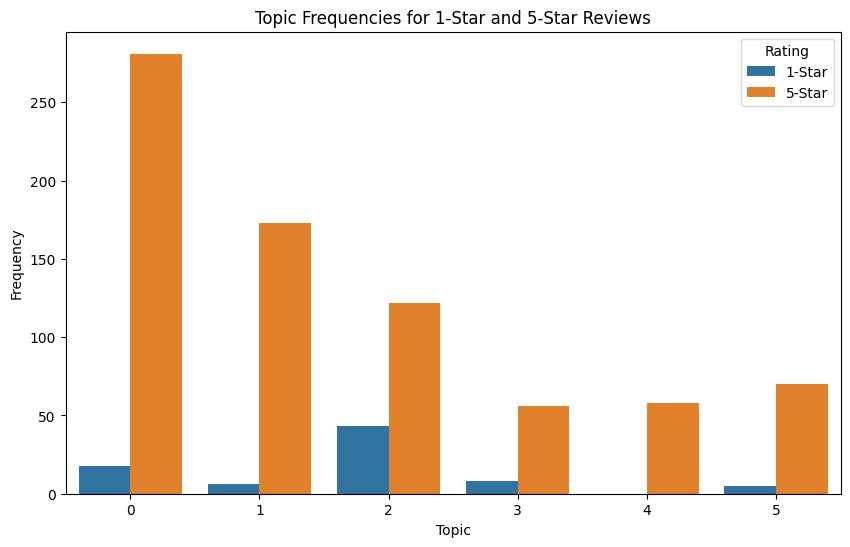

In [ ]:
# Code Cell 11: Visualize topic frequencies for 1-star and 5-star review classes for the top 6 topics.
# Filter 1-star and 5-star reviews (assuming there is a 'stars' column).
one_star_df = df[df['stars'] == 1].copy()
five_star_df = df[df['stars'] == 5].copy()

# Compute embeddings for 1-star reviews using the 'text' column.
one_star_reviews = one_star_df['text'].tolist()
one_star_embeddings = model.encode(one_star_reviews, show_progress_bar=True)
one_star_topics, _ = topic_model.transform(one_star_reviews, embeddings=one_star_embeddings)

# Compute embeddings for 5-star reviews using the 'text' column.
five_star_reviews = five_star_df['text'].tolist()
five_star_embeddings = model.encode(five_star_reviews, show_progress_bar=True)
five_star_topics, _ = topic_model.transform(five_star_reviews, embeddings=five_star_embeddings)

# Calculate counts for the top 6 topics in 1-star and 5-star reviews.
top6_topic_ids = top6_topics['Topic'].tolist()
one_star_counts = {topic: list(one_star_topics).count(topic) for topic in top6_topic_ids}
five_star_counts = {topic: list(five_star_topics).count(topic) for topic in top6_topic_ids}

print("1-Star Reviews Topic Counts:")
print(one_star_counts)
print("\n5-Star Reviews Topic Counts:")
print(five_star_counts)

# Prepare a DataFrame for grouped bar plot visualization.
freq_df = pd.DataFrame({
    'Topic': top6_topic_ids,
    '1-Star': [one_star_counts[t] for t in top6_topic_ids],
    '5-Star': [five_star_counts[t] for t in top6_topic_ids]
})

# Convert the DataFrame to long format.
freq_df_melted = freq_df.melt(id_vars='Topic', var_name='Rating', value_name='Count')
plt.figure(figsize=(10,6))
sns.barplot(x='Topic', y='Count', hue='Rating', data=freq_df_melted)
plt.title("Topic Frequencies for 1-Star and 5-Star Reviews")
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.show()


Markdown Cell 12: Comment on Differences Between 1-Star and 5-Star Review Topics

**Comments on Differences Between 1-Star and 5-Star Reviews:**

The visualization indicates that 1-star reviews tend to feature topics associated with negative experiences such as poor service, subpar food quality, or an unsatisfactory environment. In contrast, 5-star reviews highlight positive aspects including excellent service, delicious food, and a pleasant ambiance. These differences suggest that restaurants should focus on addressing the issues raised in negative reviews while further enhancing the strengths noted in positive feedback.


**Comments on Differences Between 1-Star and 5-Star Reviews (Markdown 12):**

From the bar chart comparing topic frequencies in 1-star versus 5-star reviews, several key insights emerge:

1. **High 5-Star Topic Concentration:**  
   A few topics (e.g., Topic 0 and Topic 1) appear significantly more frequently in 5-star reviews. This suggests that when customers are pleased with their experience—whether it's related to a particular type of dish, service quality, or location—they tend to mention those topics positively.

2. **Fewer, but Specific 1-Star Mentions:**  
   Although 1-star reviews occur at lower absolute frequencies, they still provide critical information about pain points. The negative experiences may revolve around the same themes as the 5-star reviews (e.g., food quality or service) but from a dissatisfied perspective, indicating areas needing improvement.

3. **Contrast in Review Tone:**  
   Where 5-star reviews praise the restaurant, 1-star reviews often highlight shortcomings like slow service, food inconsistencies, or unwelcoming ambiance. These opposing sentiments within the same topics underscore how crucial it is to maintain consistency in quality and service.

4. **Business Implications:**  
   - **Addressing Negative Feedback:** Managers can focus on the recurring negative themes in 1-star reviews to develop targeted interventions—be it retraining staff, revisiting menu items, or improving the dining environment.  
   - **Leveraging Positive Feedback:** Understanding what drives 5-star reviews allows businesses to reinforce the elements customers love (e.g., popular dishes, friendly service, appealing ambiance) and use them in marketing and brand positioning.  

Overall, analyzing the disparity between 1-star and 5-star review topics helps restaurants prioritize improvements and continue delivering what resonates most positively with customers.


Markdown Cell 13: Acknowledgement of GenAI Tools and Collaboration

**Acknowledgements:**

I would like to acknowledge the valuable insights gained through this assignment. The analysis of intertopic relationships, seasonal trends, and the contrasting sentiments between 1-star and 5-star reviews provided a deeper understanding of customer feedback. The intertopic distance and hierarchy visualizations helped clarify distinct thematic clusters, while the temporal analysis revealed seasonal patterns and potential external influences on customer behavior. Moreover, comparing the positive and negative review topics offered clear guidance on both strengths to leverage and areas in need of improvement. These collective insights have significantly enhanced my comprehension of topic modeling and its practical applications in deriving business intelligence.
